In [1]:
!python --version

Python 3.10.10


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skreducedmodel.reducedbasis import ReducedBasis
from skreducedmodel.empiricalinterpolation import EmpiricalInterpolation
from skreducedmodel.reducedbasis import normalize_set, error
from skreducedmodel.surrogate import Surrogate

In [3]:
#autoreload permite que jupyter vea las modif de los script de forma automática
%load_ext autoreload
%autoreload 2

Importamos datos

In [4]:
path = "tests/waveforms/"
q_train = np.load(path+"q_train_1d-seed_eq_1.npy")
q_test = np.load(path+"q_test_1d-seed_eq_1.npy")
ts_train = np.load(path+"ts_train_1d-seed_eq_1.npy")
ts_test = np.load(path+"ts_test_1d-seed_eq_1.npy")
times = np.load(path+"times_1d-seed_eq_1.npy")
# ts_test_normalized = normalize_set(ts_test, times)

# Reduced Basis

q = [8. 0. 0.]


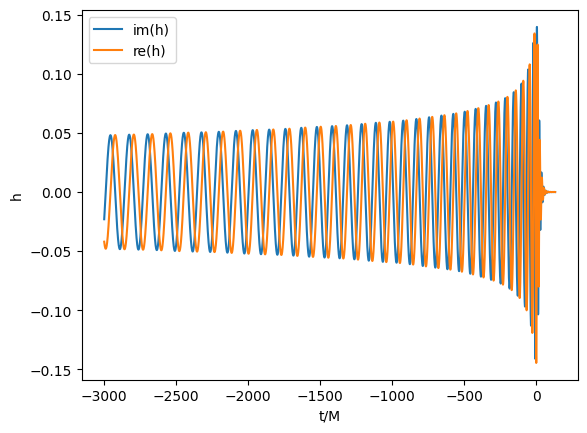

In [5]:
idx = 1
print(f"q = {q_train[idx]}")
plt.xlabel("t/M")
plt.ylabel("h")
plt.plot(times,np.imag(ts_train[idx]), label="im(h)")
plt.plot(times,np.real(ts_train[idx]), label="re(h)")
plt.legend();

Importamos la clase ReducedBasis, diseñada al estilo sci-kit y entrenamos un modelo hp-greedy.

In [6]:
rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

(100, 31300)
(100,)
(39, 31300)
(39,)
(15, 31300)
(15,)
(24, 31300)
(24,)
(61, 31300)
(61,)
(36, 31300)
(36,)
(25, 31300)
(25,)


Visualizamos el orden de las particiones realizadas

In [7]:
from anytree import RenderTree

def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

visual_tree(rb.tree)

(0,)
├── (0, 0)
│   ├── (0, 0, 0)
│   └── (0, 0, 1)
└── (0, 1)
    ├── (0, 1, 0)
    └── (0, 1, 1)


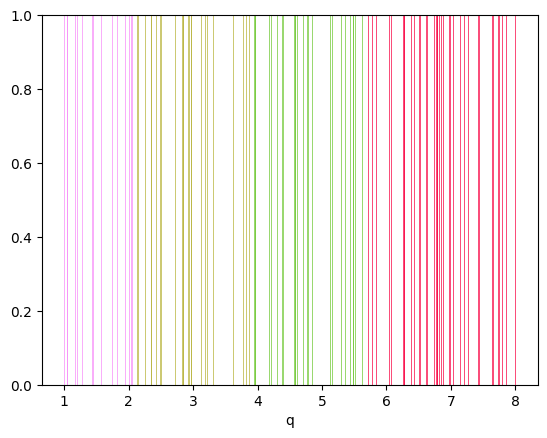

In [8]:
np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Vemos el error en función del parámetro q

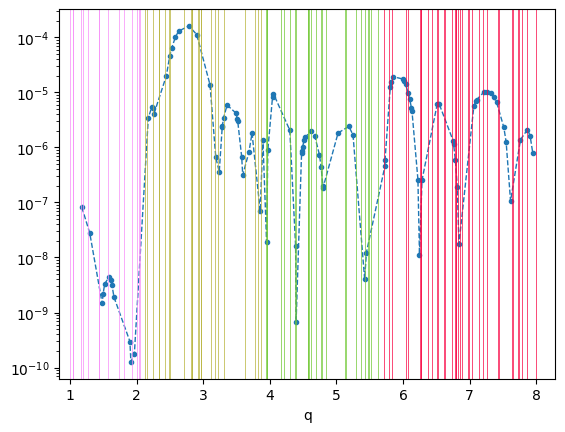

In [9]:
from skreducedmodel.reducedbasis import normalize_set, error

# normalizamos el conjunto de ondas de testeo
ts_test_normalized = normalize_set(ts_test, times)

# calculamos la proyección de las ondas con el modelo hp-greedy
hts = []
for h, q in zip(ts_test_normalized, q_test):
    hts.append(rb.transform(h,q))
hts = np.array(hts)

# calculamos el error para cada una de las proyecciones
errors = []
for i in range(ts_test_normalized.shape[0]):
    errors.append(error(ts_test_normalized[i], hts[i], times))

# graficamos la dependencia de los errores con respecto al parámetro q
plt.yscale("log")
plt.plot(np.sort(q_test[:,0]), np.array(errors)[np.argsort(q_test[:,0])], "o--", ms=3, lw=1);

np.random.seed(seed=4)
plt.xlabel("q")
for leaf in rb.tree.leaves:
    color = np.random.rand(3,)
    for p in leaf.train_parameters[:,0]:
        plt.axvline(p,c=color,lw=.5)

Ploteamos una onda proyectada vs la normal

/home/fcerino/env_skrm/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


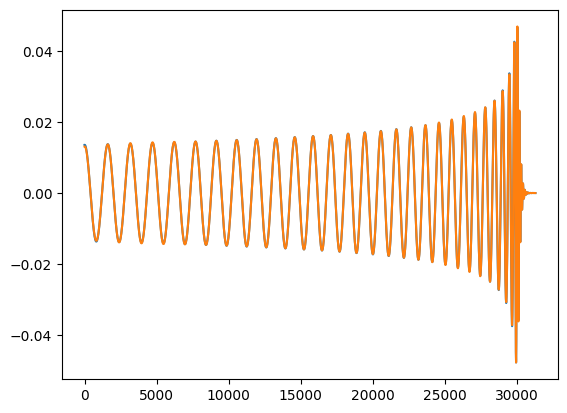

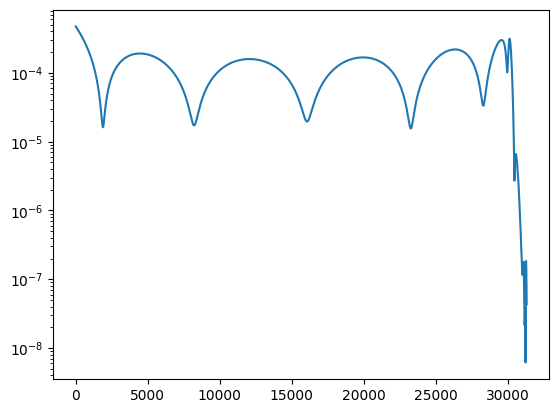

In [10]:
plt.plot(h)
plt.plot(rb.transform(h,q));
plt.show()

plt.yscale("log")
plt.plot(abs(h-rb.transform(h,q)));

Veamos la variación del error frente a diferentes hiperparámetros Lmax y Nmax

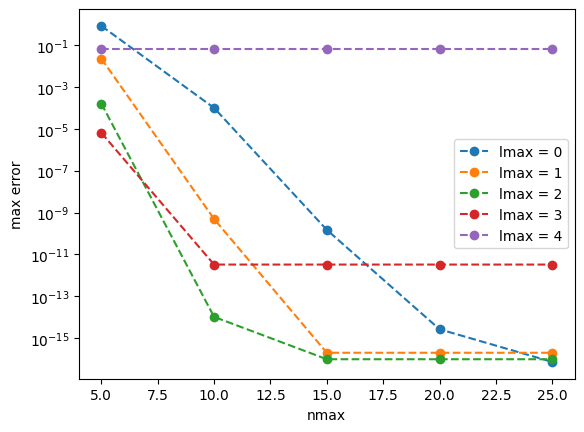

In [11]:
from skreducedmodel.reducedbasis import ReducedBasis

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

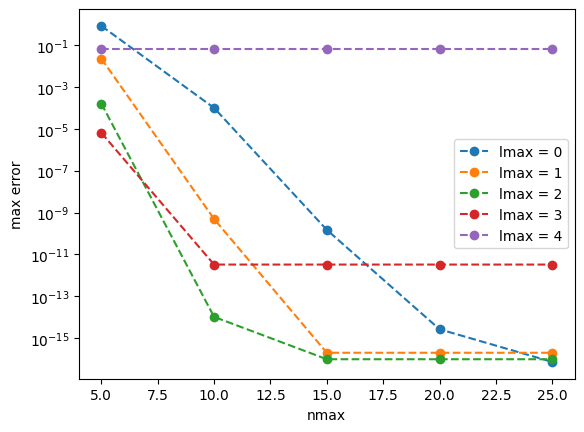

In [17]:
from skreducedmodel.reducedbasis import ReducedBasis

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = 0,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

En el enfoque de bases reducidas, una menor dimensionalidad de la base implica representaciones con menor costo computacional para ser evaluadas.

Se puede ver que existen casos que para llegar a una precision dada, al particionar el dominio se obtienen bases con dimensionalidad menor que una global.

Por ejemplo, para llegar a representaciones con error máximo de ~ 10e(-14), con lmax = 0 (sin particion) se necesita una base de dimension ~20, mientras con lmax=2 se necesitan bases de a lo sumo dimensión 10.

Ahora probamos el mismo experimento con otra semilla:

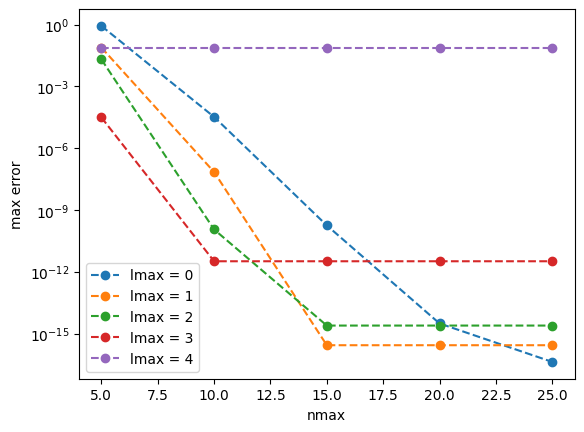

In [12]:
index_seed_global_rb = -1

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

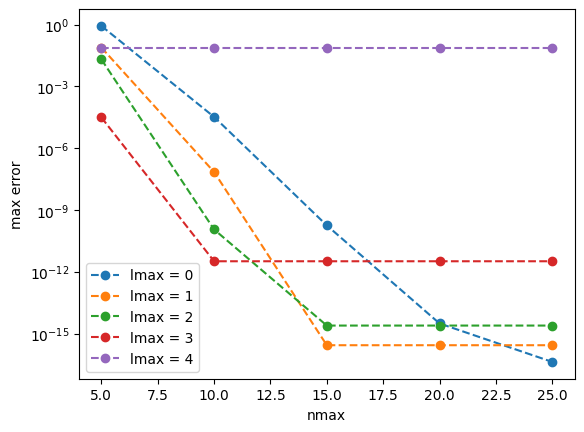

In [18]:
index_seed_global_rb = -1

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors = []
    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )

        errors = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            ht = rb.transform(h,q)
            # calculamos el error para la proyección
            errors.append(error(h, ht, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors.append(np.max(errors))
    plt.plot(range_nmax, max_errors, "o--", label = f"lmax = {lmax}")
plt.legend();

Se puede ver que hay una dependencia de los errores con respecto a la semilla.

Por lo tanto, esta se puede tomar como un hiperparámetro "relevante" del modelo.

Se menciona como "relevante" debido a que en el caso sin partición la elección de la semilla otorga resultados que se pueden tomar como equivalentes, debido a que en estudios realizados anteriormente se muestra como esta no afecta a la capacidad de representacion de las bases resultantes, más allá de que estas pueden no ser construidas exactamente con los mismos elementos del espacio de entrenamiento.

---------

# EIM

In [13]:
rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 0,
                  nmax = np.inf,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train,
       parameters = q_train,
       physical_points = times
       )

eim = EmpiricalInterpolation(reduced_basis=rb)

In [14]:
eim.fit() 

In [15]:
eim.reduced_basis.tree.leaves[0].is_leaf

True

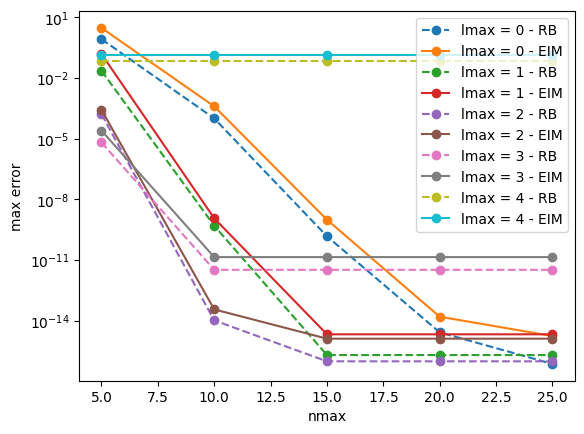

In [16]:
index_seed_global_rb = 0

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []

    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )
        
        eim = EmpiricalInterpolation(reduced_basis=rb)
        eim.fit()
        
        errors_rb = []
        errors_eim = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rb.transform(h,q)
            h_eim = eim.transform(h,q)
            
            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        
    plt.plot(range_nmax, max_errors_rb, "o--", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")

plt.legend();

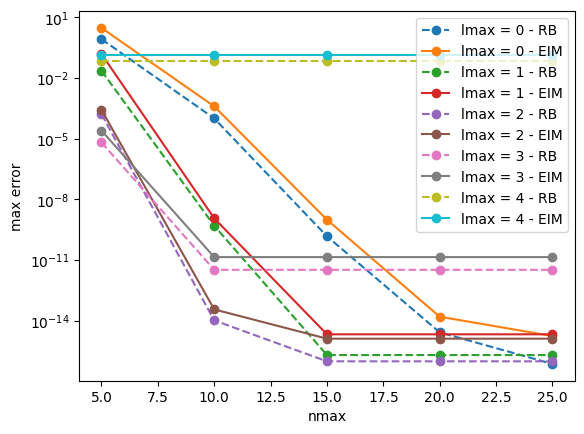

In [23]:
index_seed_global_rb = 0

range_lmax = range(0,5)
range_nmax = range(5,26,5)

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")


for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []

    for nmax in range_nmax:
        rb = ReducedBasis(index_seed_global_rb = index_seed_global_rb,
                          greedy_tol = 1e-16,
                          lmax = lmax,
                          nmax = nmax,
                          normalize = True,
                          integration_rule="riemann"
                          )

        rb.fit(training_set = ts_train,
               parameters = q_train,
               physical_points = times
               )
        
        eim = EmpiricalInterpolation(reduced_basis=rb)
        eim.fit()
        
        errors_rb = []
        errors_eim = []
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rb.transform(h,q)
            h_eim = eim.transform(h,q)
            
            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        
    plt.plot(range_nmax, max_errors_rb, "o--", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")

plt.legend();

si no le quiero dar una rb y que se resuelva automaticamente por detras:


eim_model = EmpiricalInterpolation()

o 

eim_model = EmpiricalInterpolation(
                  reducedbasis= rb 
                  )

# Surrogate

In [17]:
rb_abs = ReducedBasis()
rb_abs.fit(training_set = np.abs(ts_train),
              parameters = q_train[:,0],
              physical_points = times
      )
eim_abs = EmpiricalInterpolation(reduced_basis=rb_abs)
eim_abs.fit()
rom_abs = Surrogate(eim=eim_abs)
rom_abs.fit()

In [18]:
rb_angle = ReducedBasis()
rb_angle.fit(training_set = np.angle(ts_train),
              parameters = q_train[:,0],
              physical_points = times
      )
eim_angle = EmpiricalInterpolation(reduced_basis=rb_angle)
eim_angle.fit()
rom_angle = Surrogate(eim=eim_angle)
rom_angle.fit()

In [19]:
rb = ReducedBasis()
rb.fit(training_set = ts_train,
              parameters = q_train[:,0],
              physical_points = times
      )
eim = EmpiricalInterpolation(reduced_basis=rb)
eim.fit()
rom = Surrogate(eim=eim)
rom.fit()

In [20]:
from arby import ReducedOrderModel as ROM

In [21]:
f_model_abs = ROM(training_set=np.abs(ts_train)[np.argsort(q_train[:,0])],
              physical_points=times,
              parameter_points= np.sort(q_train[:,0])
             )

In [22]:
f_model_angle = ROM(training_set=np.angle(ts_train)[np.argsort(q_train[:,0])],
                    physical_points=times,
                    parameter_points= np.sort(q_train[:,0])
                   )

In [23]:
errors_rom = []
errors_arby = []
errors_decomposition = []
for h, q in zip(ts_test, q_test):
    # calculamos la proyección de las ondas con el modelo hp-greedy
    h_rom = rom.predict(q[0])
    h_arby = f_model_abs.surrogate(q[0]) * np.exp(1j*f_model_angle.surrogate(q[0]))
    h_dec = rom_abs.predict(q[0]) * np.exp(1j*rom_angle.predict(q[0]))

    # calculamos el error para la estimación
    errors_rom.append(error(h, h_rom, times))
    errors_arby.append(error(h, h_arby, times))
    errors_decomposition.append(error(h, h_dec, times))

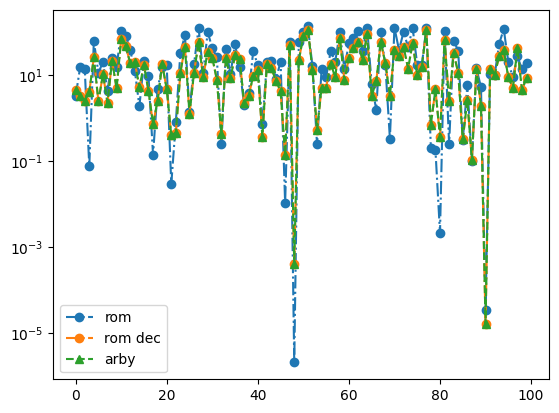

In [24]:
plt.yscale("log")
plt.plot(errors_rom,"o-.",label="rom")
plt.plot(errors_decomposition,"o-.",label="rom dec")
plt.plot(errors_arby,"^--",label="arby")
plt.legend();

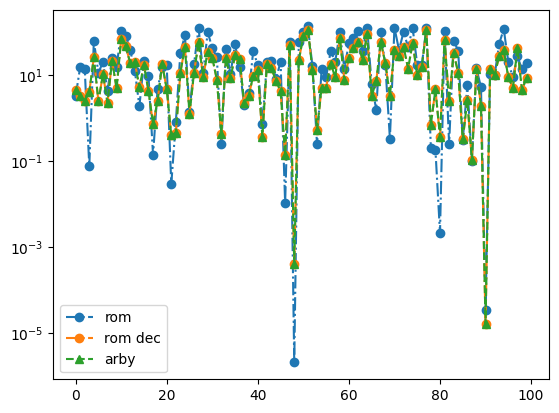

In [41]:
plt.yscale("log")
plt.plot(errors_rom,"o-.",label="rom")
plt.plot(errors_decomposition,"o-.",label="rom dec")
plt.plot(errors_arby,"^--",label="arby")
plt.legend();

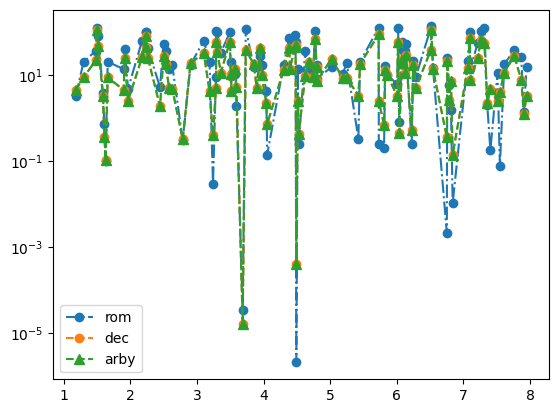

In [14]:
plt.yscale("log")
x = np.sort(q_test[:,0])
argsort = np.argsort(q_train[:,0])
plt.plot(x,np.real(errors_rom)[argsort],"o-.",label="rom")
plt.plot(x,np.real(errors_decomposition)[argsort],"o--",label="dec")
plt.plot(x,np.real(errors_arby)[argsort],"^--",ms=7,label="arby")
#plt.plot(x,np.array(errors_eim)[argsort],"o--",label="eim")
#plt.plot(x,np.array(errors_rb)[argsort],"o--",label="rb")
plt.legend()

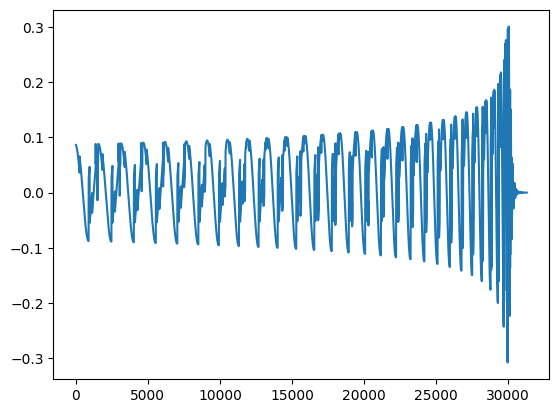

In [25]:
plt.plot(h_dec)

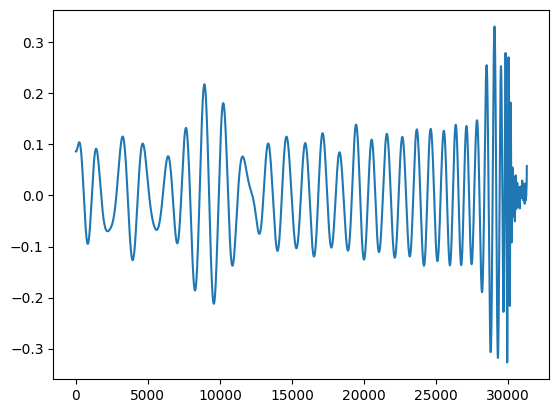

In [26]:
plt.plot(h_rom)

# funcionalidad

In [27]:
# para EIM 
# forma 1
eim_model = EmpiricalInterpolation(reduced_basis=rb)
eim_model.fit()

# forma 2

# inicializa una base reducida con los hiperparámetros standar
eim_model = EmpiricalInterpolation()

# entrenamiento de la base reducida
eim_model.reduced_basis.fit(training_set = ts_train,
                            parameters = q_train[:,0],
                            physical_points = times
                           )
# entrenamiento del modelo de interpolación empírica
eim_model.fit()

In [28]:
# para Surrogate

# forma 1
surrogate = Surrogate()
surrogate.eim.reduced_basis.fit(training_set = ts_train,
                                parameters = q_train[:,0],
                                physical_points = times
                               )
surrogate.eim.fit()
surrogate.fit()

# forma 2

surrogate = Surrogate(eim=eim_model)
surrogate.fit()

In [29]:
import inspect

class ExampleClass:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

input_variables = inspect.getargspec(ExampleClass.__init__).args[1:]
print(input_variables)

['a', 'b', 'c']


/tmp/ipykernel_7459/3996298323.py:9: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  input_variables = inspect.getargspec(ExampleClass.__init__).args[1:]


# mksurrogate tests

In [30]:
from skreducedmodel.mksurrogate import mksurrogate

In [31]:
rb = ReducedBasis()
surrogate = mksurrogate(instance=rb)

TypeError: ReducedBasis.fit() missing 3 required positional arguments: 'training_set', 'parameters', and 'physical_points'

In [32]:
eim = EmpiricalInterpolation()
surrogate = mksurrogate(instance=2)

InputError: if 'instance' is given, must be an instance of EmpiricalInterpolation or ReducedBasis.

In [33]:
eim = EmpiricalInterpolation()
surrogate = mksurrogate(parameters=q_train[:,0],
                        training_set=ts_train,
                        physical_points=times,
                        instance=eim
                       )

InputError: A reduced basis or eim instance is not needed as input if training data is given. In case hyperparameters want to be specified, they must be kwargs.

In [34]:
rb = ReducedBasis()
surrogate = mksurrogate(parameters=q_train[:,0],
                        training_set=ts_train,
                        physical_points=times,
                        instance=rb
                       )

InputError: A reduced basis or eim instance is not needed as input if training data is given. In case hyperparameters want to be specified, they must be kwargs.

In [35]:
surrogate = mksurrogate(parameters=q_train[:,0],
                        training_set=ts_train,
                        physical_points=times
                       )
assert surrogate.is_trained

In [36]:
surrogate = mksurrogate(lmax=1,
                        parameters=q_train[:,0],
                        training_set=ts_train,
                        physical_points=times
                       )
assert surrogate.is_trained

In [37]:
rb = ReducedBasis()
rb.fit(parameters=q_train[:,0],
       training_set=ts_train,
       physical_points=times
      )
surrogate = mksurrogate(rb,lmax = 1)
# tiene que dar error

InputError: If an instance of ReducedBasis is given, must not be given hyperparameters of it.

In [ ]:
list(inspect.signature(ReducedBasis.__init__).parameters)[1:]

----

In [38]:
rb = ReducedBasis()
rb.fit(parameters=q_train[:,0],
                        training_set=ts_train,
                        physical_points=times)


In [39]:
surrogate = mksurrogate(rb,poly_deg=5)

In [40]:
surrogate

# pipeline 

In [6]:
from sklearn.pipeline import Pipeline

In [11]:
estimators = [('reduced_basis', ReducedBasis()),
              ('eim', EmpiricalInterpolation()),
              ("surrogate",Surrogate())
             ]
pipe = Pipeline(estimators)

In [13]:
pipe.steps

[('reduced_basis',
  <skreducedmodel.reducedbasis.ReducedBasis at 0x7f2205f324a0>),
 ('eim',
  <skreducedmodel.empiricalinterpolation.EmpiricalInterpolation at 0x7f2205f31690>),
 ('surrogate', <skreducedmodel.surrogate.Surrogate at 0x7f2205f32320>)]

In [16]:
pipe.fit(Y = ts_train,
       X = q_train,
       physical_points = times
       )

ValueError: Pipeline.fit does not accept the Y parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

# hp-surrogate

In [9]:
rom = Surrogate(lmax=1, nmax = 20, greedy_tol = 1e-16)
rom.fit(training_set=ts_train,
              parameters=q_train[:,0],
              physical_points=times)

len(rom.base.tree.leaves)

2

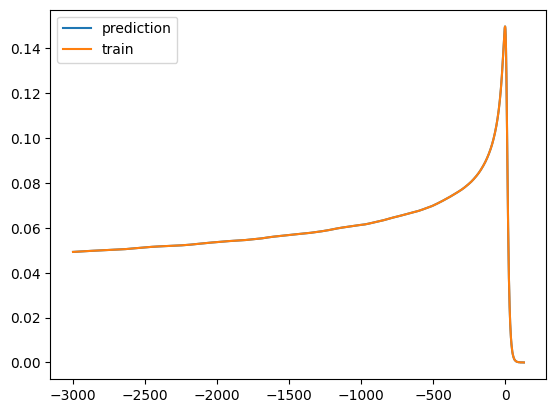

In [10]:
idx = 3
plt.plot(times, rom.predict(q_train[idx,0]), label="prediction")
plt.plot(times, ts_train[idx], label="train")
plt.legend()

NameError: name 'ts_test_normalized' is not defined

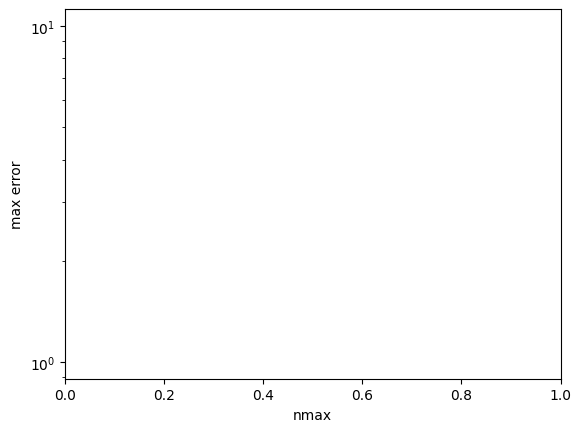

In [6]:
index_seed_global_rb = 0

range_lmax = range(0,3)
range_nmax = [5,13,25]

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")

for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []
    max_errors_rom = []

    for nmax in range_nmax:
        rom = Surrogate(lmax = lmax,
                        nmax = nmax,
                        greedy_tol = 1e-16
                       )
        rom.fit(training_set=ts_train,
                      parameters=q_train[:,0],
                      physical_points=times)

        errors_rb = []
        errors_eim = []
        errors_rom = []      
        for h, q in zip(ts_test_normalized, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rom.base.transform(h,q[0])
            h_eim = rom.eim.transform(h,q[0])
            h_rom = rom.predict(q[0])

            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))
            errors_rom.append(error(h, h_rom, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        max_errors_rom.append(np.max(errors_rom))

   # plt.plot(range_nmax, max_errors_rb, "o-", label = f"lmax = {lmax} - RB")
    plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")
    plt.plot(range_nmax, max_errors_rom, "o--", label = f"lmax = {lmax} - ROM")

plt.legend();

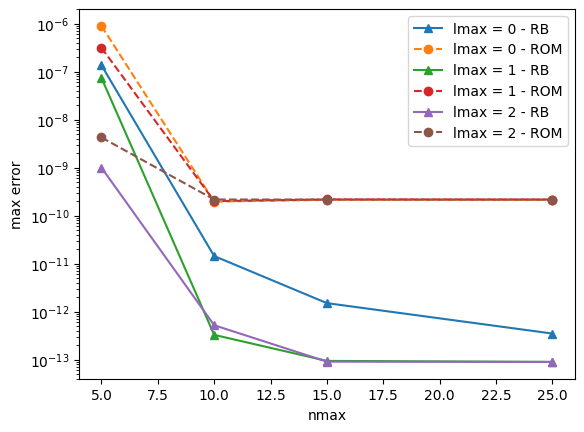

In [32]:
range_lmax = range(0,3)
range_nmax = [5,10,15,25]

plt.yscale("log")
plt.xlabel("nmax")
plt.ylabel("max error")

for lmax in range_lmax:
    max_errors_rb = []
    max_errors_eim = []
    max_errors_rom = []

    for nmax in range_nmax:
        rom = Surrogate(lmax = lmax,
                        nmax = nmax,
                        greedy_tol = 1e-16,
                        normalize = False
                       )
        rom.fit(training_set = ts_train,
                      parameters = q_train[:,0],
                      physical_points = times
               )

        errors_rb = []
        errors_eim = []
        errors_rom = []      
        for h, q in zip(ts_test, q_test):
            # calculamos la proyección de las ondas con el modelo hp-greedy
            h_rb = rom.base.transform(h,q[0])
            h_eim = rom.eim.transform(h,q[0])
            h_rom = rom.predict(q[0])

            # calculamos el error para la proyección
            errors_rb.append(error(h, h_rb, times))
            errors_eim.append(error(h, h_eim, times))
            errors_rom.append(error(h, h_rom, times))

        # tomamos el error máximo en el conjunto de validación
        max_errors_rb.append(np.max(errors_rb))
        max_errors_eim.append(np.max(errors_eim))
        max_errors_rom.append(np.max(errors_rom))

    plt.plot(range_nmax, max_errors_rb, "^-", label = f"lmax = {lmax} - RB")
    #plt.plot(range_nmax, max_errors_eim, "o-", label = f"lmax = {lmax} - EIM")
    plt.plot(range_nmax, max_errors_rom, "o--", label = f"lmax = {lmax} - ROM")

plt.legend();